# Automatic Musical Style Classifier

In [195]:
# Basic environment and settings
dataset_path = '/home/phil/mtlpy57/genres2'
genres = ['fresh-edm', 'jazz-classics','kick-ass-metal', 'lost-classics', 'teen-pop', 'your-favorite-coffeehouse']
cmap_name = 'jet'

## Load a Spark dataframe with raw audio data

In [196]:
import array
import os
import wave
from pyspark.sql.types import *

inputs = []

for i, genre in enumerate(genres):
    for j in range(25):
        inputs.append((i, os.path.join(dataset_path, genre, '%s.%05d.wav' % (genre, j))))


def load_audio(row):
    genre_index, filename = row
    reader = wave.open(filename, "rb")
    frames = reader.readframes(reader.getnframes())
    return (genre_index, os.path.basename(filename), frames)


music_samples = sqlContext.createDataFrame(
    sc.parallelize(inputs).map(load_audio),
    schema=StructType([
        StructField('genre_index', IntegerType(), False),
        StructField('filename', StringType(), False),
        StructField('frames', BinaryType(), False),
    ]));

## Create feature extractors and execute them

In [197]:
import shutil

import librosa
import numpy as np
import scipy.stats

from pyspark.sql.functions import udf


sample_rate = 22050


def _zero_crossing_rate(frames):
    """Estimate timbre from zero crossing rate in audio signal."""
    frames = np.frombuffer(frames, dtype=np.int16).astype('float32')
    zcr = librosa.feature.zero_crossing_rate(y=frames) * sample_rate
    return list(map(float, [zcr.mean()]))
zero_crossing_rate = udf(_zero_crossing_rate, ArrayType(DoubleType()))


def _ceps(frames):
    """Return statistics on perceptual frequency content."""
    frames = np.frombuffer(frames, dtype=np.int16).astype('float32')
    mfcc = librosa.feature.mfcc(y=frames, sr=sample_rate)
    return list(map(float, mfcc[1:, 100::100].var(axis=0)))
ceps = udf(_ceps, ArrayType(DoubleType()))


def _tempo(frames):
    """Identify rythmic features like tempo."""
    frames = np.frombuffer(frames, dtype=np.int16).astype('float32')
    oenv = librosa.onset.onset_strength(y=frames, sr=sample_rate)
    tempo = librosa.beat.estimate_tempo(oenv, sr=sample_rate, start_bpm=120)
    return list(map(float, [tempo]))
tempo = udf(_tempo, ArrayType(DoubleType()))


def _energy(frames):
    """Measure sound energy, noisiness and perceived loudness."""
    frames = np.frombuffer(frames, dtype=np.int16).astype('float32')
    dynamic_range = 20. * np.log10(np.abs(frames).max() / np.abs(frames).mean())
    loudness = 20. * np.log10(np.sqrt(np.square(frames).mean()) / 32767.)
    
    S, phase = librosa.magphase(librosa.stft(y=frames))
    # entropy = 20. * np.log10(np.exp(np.log10(S).mean(axis=1)) / S.mean(axis=1)).mean()
    #
    # Redefine "flatness" as the ratio of RMS(spectrum) over average spectrum magnitude to
    # avoid problems with empty frequency bins that throw off the geometric mean.
    entropy = 20. * np.log10((S.mean(axis=1) / np.sqrt(np.square(S).mean(axis=1))).mean())

    return list(map(float, [dynamic_range, loudness, entropy]))
energy = udf(_energy, ArrayType(DoubleType()))


def _chroma(frames):
    """Find which notes are more present in audio sample."""
    frames = np.frombuffer(frames, dtype=np.int16).astype('float32')
    chroma = librosa.feature.chroma_stft(y=frames, sr=sample_rate, n_fft=4096)
    return list(map(float, chroma.mean(axis=1)))
chroma = udf(_chroma, ArrayType(DoubleType()))


# Clean up output, no way back.
if os.path.exists('features'):
    shutil.rmtree('features')

# Execute the feature extractors and save result to disk as JSON lines.
music_samples\
    .select(
        'genre_index',
        'filename',
        zero_crossing_rate('frames').alias('zero_crossing_rate'),
        ceps('frames').alias('mfcc_variance'),
        tempo('frames').alias('tempo'),
        energy('frames').alias('energy'),
        chroma('frames').alias('chroma'))\
    .write \
    .format('json') \
    .save('features')

In [198]:
import glob
import json
import pandas as pd


# Read back the JSON data and build a Pandas dataframe.
features = pd.concat([
    pd.DataFrame.from_records([
        json.loads(line) for line in open(filename)
    ]) for filename in glob.glob('features/part-*')
])

# What does it look like?
features[:1]

,chroma,energy,filename,genre_index,mfcc_variance,tempo,zero_crossing_rate
0,"[0.3493616857410438, 0.21991420269393386, 0.18...","[20.091063976287842, -21.70336717607161, -6.79...",lost-classics.00000.wav,3,"[1404.743214865423, 958.8648237506892, 1130.10...",[92.28515625],[1639.0274944021633]


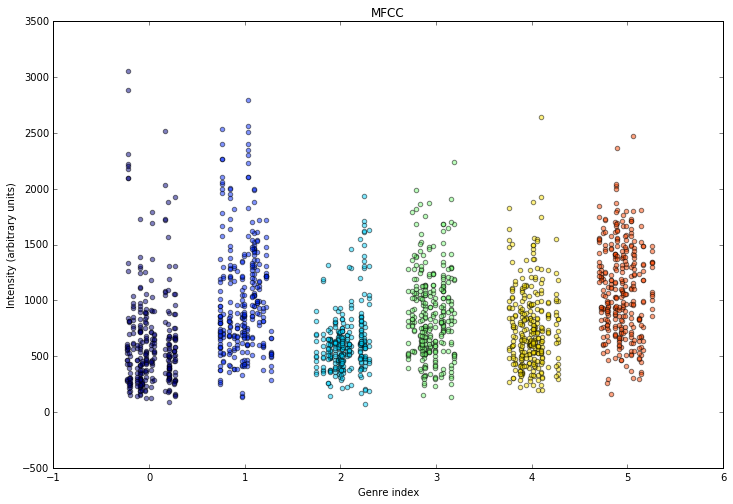

In [302]:
%matplotlib inline
import matplotlib.pyplot as plt

cm = plt.get_cmap(cmap_name)

fig = plt.figure(figsize=(12, 8))
for genre_index, mfcc in features[['genre_index', 'mfcc_variance']].values:
    jitter = np.random.uniform(-0.3, 0.3)
    plt.scatter([genre_index + jitter] * len(mfcc), mfcc, c=cm(1. * genre_index / len(genres)), alpha=0.5)
plt.title('MFCC')
plt.xlabel('Genre index')
plt.ylabel('Intensity (arbitrary units)');

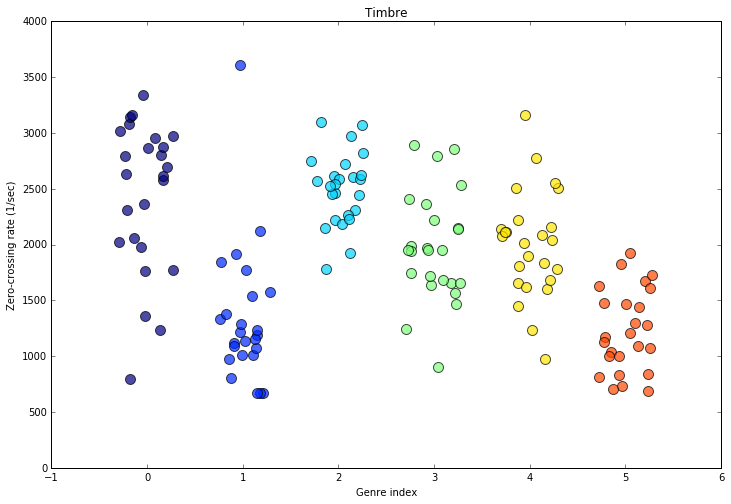

In [303]:
fig = plt.figure(figsize=(12, 8))
for genre_index, cross in features[['genre_index', 'zero_crossing_rate']].values:
    jitter = np.random.uniform(-0.3, 0.3)
    plt.scatter([genre_index + jitter], cross[0], c=cm(1. * genre_index / len(genres)), s=100, alpha=0.7)
plt.title('Timbre')
plt.xlabel('Genre index')
plt.ylabel('Zero-crossing rate (1/sec)');

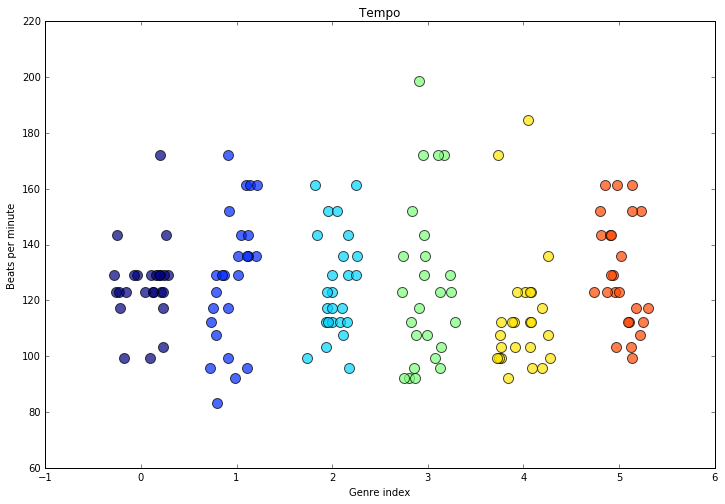

In [304]:
fig = plt.figure(figsize=(12, 8))
for genre_index, track_tempo in features[['genre_index', 'tempo']].values:
    jitter = np.random.uniform(-0.3, 0.3)
    plt.scatter([genre_index + jitter] * len(track_tempo), track_tempo, c=cm(1. * genre_index / len(genres)), s=100, alpha=0.7)
plt.title('Tempo')
plt.xlabel('Genre index')
plt.ylabel('Beats per minute');

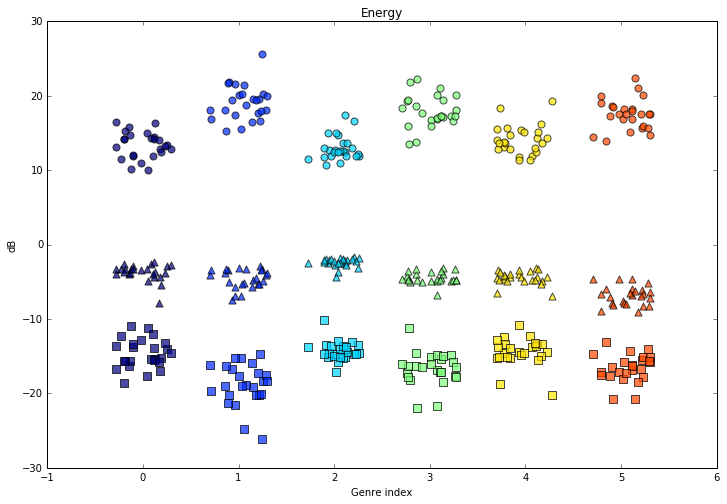

In [202]:
fig = plt.figure(figsize=(12, 8))
for genre_index, track_energy in features[['genre_index', 'energy']].values:
    jitter = np.random.uniform(-0.3, 0.3)
    plt.scatter([genre_index + jitter], track_energy[0], c=cm(1. * genre_index / len(genres)), alpha=0.7, s=50)
    plt.scatter([genre_index + jitter], track_energy[1], c=cm(1. * genre_index / len(genres)), alpha=0.7, s=50, marker='s')
    plt.scatter([genre_index + jitter], track_energy[2], c=cm(1. * genre_index / len(genres)), alpha=0.7, s=50, marker='^')
plt.title('Energy')
plt.xlabel('Genre index')
plt.ylabel('dB');

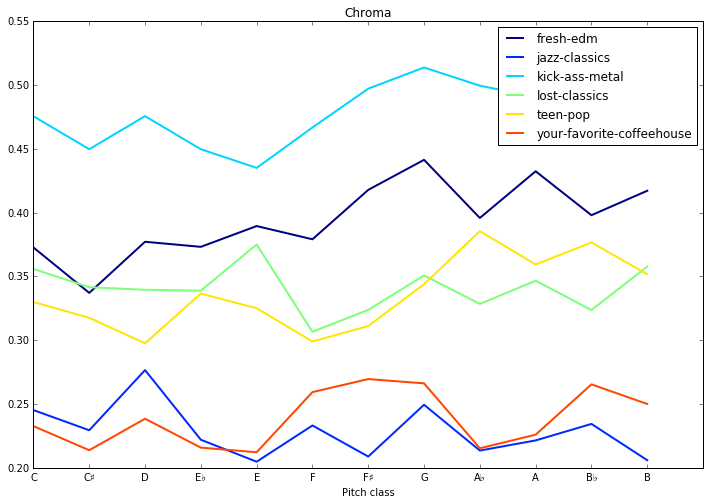

In [305]:
import matplotlib
matplotlib.rc('font', family='DejaVu Sans')

fig = plt.figure(figsize=(12, 8))
values = list(features.groupby('genre_index')['chroma'].aggregate(lambda x: list(np.array(list(x)).mean(axis=0))).values)
for genre_index, chroma_values in enumerate(values):
    plt.plot(range(12), chroma_values, c=cm(1. * genre_index / len(genres)), linewidth=2.0, label=genres[genre_index])
plt.title('Chroma')
plt.xlabel('Pitch class')
plt.xticks(range(12), ['C', u'C♯', 'D', u'E♭', 'E', 'F', u'F♯', 'G', u'A♭', 'A', u'B♭', 'B'])
# plt.ylabel('Probability') ??
plt.legend();

## Create the feature matrix and prepare cross-validation

In [306]:
from sklearn.cross_validation import train_test_split

X = (
    features[['zero_crossing_rate', 'mfcc_variance', 'tempo', 'energy', 'chroma']]
    .apply(lambda x: x[0] + sorted(x[1])[:12] + x[2] + x[3] + sorted(x[4]), axis=1)
    .values)
numfeatures = len(X[0])
print("Training on {} features".format(numfeatures))
X = np.vstack([x[:numfeatures] for x in X]).astype(np.float)
y = features['genre_index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Training on 29 features


## Train the model

In [308]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier


n_components = 2

lda = LinearDiscriminantAnalysis(n_components=n_components)
X_r = lda.fit(X_train, y_train).transform(X_train)
X_test_r = lda.transform(X_test)

knn = KNeighborsClassifier(weights='distance')
knn.fit(X_r, y_train)
y_predicted = knn.predict(X_test_r)

for guess in sorted(zip((genres[i] for i in y_predicted), (genres[j] for j in y_test))):
    print(int(guess[0] == guess[1]), guess)

print()
print('Accuracy:', knn.score(X_test_r, y_test))
print('meh')

1 ('fresh-edm', 'fresh-edm')
1 ('fresh-edm', 'fresh-edm')
0 ('fresh-edm', 'kick-ass-metal')
0 ('fresh-edm', 'kick-ass-metal')
0 ('fresh-edm', 'teen-pop')
0 ('fresh-edm', 'teen-pop')
0 ('fresh-edm', 'teen-pop')
0 ('fresh-edm', 'teen-pop')
1 ('jazz-classics', 'jazz-classics')
1 ('jazz-classics', 'jazz-classics')
1 ('jazz-classics', 'jazz-classics')
0 ('jazz-classics', 'lost-classics')
1 ('kick-ass-metal', 'kick-ass-metal')
1 ('kick-ass-metal', 'kick-ass-metal')
1 ('kick-ass-metal', 'kick-ass-metal')
0 ('lost-classics', 'fresh-edm')
0 ('lost-classics', 'kick-ass-metal')
1 ('lost-classics', 'lost-classics')
1 ('lost-classics', 'lost-classics')
1 ('lost-classics', 'lost-classics')
0 ('lost-classics', 'your-favorite-coffeehouse')
0 ('teen-pop', 'lost-classics')
1 ('teen-pop', 'teen-pop')
1 ('teen-pop', 'teen-pop')
1 ('teen-pop', 'teen-pop')
0 ('teen-pop', 'your-favorite-coffeehouse')
0 ('your-favorite-coffeehouse', 'jazz-classics')
0 ('your-favorite-coffeehouse', 'jazz-classics')
0 ('your-fa

## Let's see what it looks like

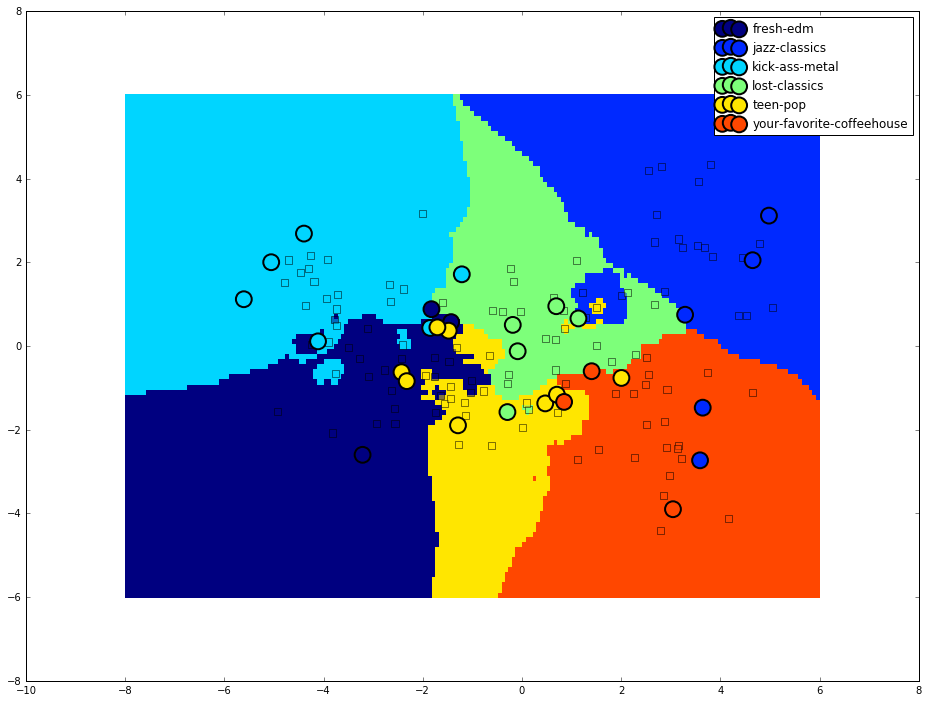

In [206]:
from matplotlib import colors


fig = plt.figure(figsize=(16, 12))
if n_components > 2:
    from mpl_toolkits.mplot3d import Axes3D
    ax = fig.add_subplot(111, projection='3d')
for i, genre in enumerate(genres):
    c = [cm(1.*i/len(genres))] * len(X_r)
    if n_components > 2:
        ax.scatter(
            X_r[y_train == i, 0],
            X_r[y_train == i, 1],
            X_r[y_train == i, 2],
            c=c, s=50, label=genre, depthshade=False)
        ax.scatter(
            X_test_r[y_test == i, 0],
            X_test_r[y_test == i, 1],
            X_test_r[y_test == i, 2],
            c=c, s=200, depthshade=False)
        ax.scatter(
            X_test_r[y_predicted == i, 0],
            X_test_r[y_predicted == i, 1],
            X_test_r[y_predicted == i, 2],
            c=c, s=50, depthshade=False)
    else:
        plt.scatter(
            X_r[y_train == i, 0],
            X_r[y_train == i, 1],
            c=c, s=50, alpha=0.5, marker='s', zorder=2)
        plt.scatter(
            X_test_r[y_test == i, 0],
            X_test_r[y_test == i, 1],
            c=c, s=250, label=genre, alpha=1.0, linewidth=2.0, zorder=3)
        #plt.scatter(
        #    X_test_r[y_predicted == i, 0],
        #    X_test_r[y_predicted == i, 1],
        #    c=c, s=250, label=genre, alpha=1.0, linewidth=2.0, zorder=10)

if n_components == 2:
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cm, norm=colors.Normalize(0, len(genres)), zorder=1)

plt.legend();

![Cute animal tax](http://www.zemwallpapers.com/wp-content/uploads/2015/07/Cuteness-Cub-Tiger-Sleeping-Wallpaper-1.jpg)

## Now we put new songs into the model

This was taken from my Last.fm profile, so it's some of the songs I listened to, mostly around 2008.

In [313]:
playlist = [s.strip() for s in open('/home/phil/mtlpy57/lastfm-top-tracks/lastfm-top-tracks.index').readlines()]
for track in playlist:
    print(track)

Björk — Earth Intruders
múm — Green Grass of Tunnel
Funkadelic — I Wanna Know If It's Good to You
Ali Farka Touré — Soko
Electrelane — Between the Wolf and the Dog
Tortoise — Four-Day Interval
Laurie Anderson — From the Air
Frank Zappa — Willie the Pimp
Björk — Like Someone in Love
Stereolab — The Flower Called Nowhere
múm — The Land Between Solar Systems
Stereolab — The Spiracles
Björk — Wanderlust
Björk — Big Time Sensuality
Stereolab — Blue Milk
Electrelane — Cut and Run
The Beatles — Here, There and Everywhere
múm — Now There's That Fear Again
Stereolab — Op Hop Detonation
Radiohead — A Wolf at the Door.
Four Tet — Hands
Emerson, Lake & Palmer — Jerusalem
Goldfrapp — Koko
DJ Shadow — Midnight in a Perfect World
Pink Floyd — One of These Days
Tycho — PBS
Philip Glass — Vessels
Helios — Paper Tiger
Add N To (X) — Buckminster Fuller
Kiss Me Deadly — Dance 2
The Go! Team — Everyone's a V.I.P. to Someone
嶺川貴子 — Flow In A Tide
Los Amigos Invisibles — San Agustín
Pizzicato Five — A New So

## Process and load results

In [210]:
lastfm_top_tracks = [(0, '/home/phil/mtlpy57/lastfm-top-tracks/lastfm-top-tracks.%05d.wav' % i) for i in range(41)]

if os.path.exists('features-personal'):
    shutil.rmtree('features-personal')

lastfm_top_tracks_samples = sqlContext\
    .createDataFrame(
        sc.parallelize(lastfm_top_tracks).map(load_audio),
        schema=StructType([
            StructField('genre_index', IntegerType(), False),
            StructField('filename', StringType(), False),
            StructField('frames', BinaryType(), False),
        ]))\
    .select(
        'filename',
        zero_crossing_rate('frames').alias('zero_crossing_rate'),
        ceps('frames').alias('mfcc_variance'),
        tempo('frames').alias('tempo'),
        energy('frames').alias('energy'),
        chroma('frames').alias('chroma'))\
    .write \
    .format('json') \
    .save('features-personal')

features_personal = pd.concat([pd.DataFrame.from_records([json.loads(line) for line in open(filename)]) for filename in glob.glob('features-personal/part-*')])
features_personal[:1]

,chroma,energy,filename,mfcc_variance,tempo,zero_crossing_rate
0,"[0.2402849460309176, 0.3193912965801546, 0.763...","[18.765435218811035, -18.36082742829333, -4.60...",lastfm-top-tracks.00020.wav,"[2018.0269457536942, 1914.0182192272887, 2099....",[123.046875],[1586.6362163212118]


## What does it look like (part 2)?

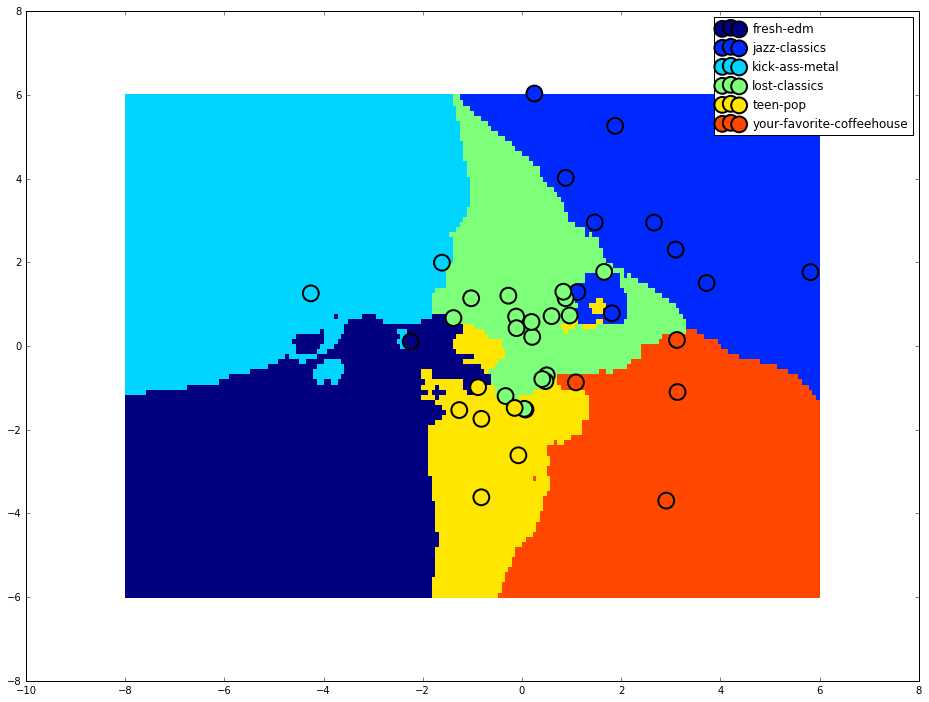

In [392]:
X_personal = (
    features_personal[['zero_crossing_rate', 'mfcc_variance', 'tempo', 'energy', 'chroma']]
    .apply(lambda x: x[0] + sorted(x[1])[:12] + x[2] + x[3] + sorted(x[4]), axis=1)
    .values)
numfeatures = len(X[0])
X_personal = np.vstack([x[:numfeatures] for x in X_personal]).astype(np.float)
X_personal_r = lda.transform(X_personal)
y_personal_predicted = knn.predict(X_personal_r)
y_personal_predicted_proba = knn.predict_proba(X_personal_r)

fig = plt.figure(figsize=(16, 12))
for i, genre in enumerate(genres):
    c = [cm(1.*i/len(genres))] * len(X_r)
    plt.scatter(
        X_personal_r[y_personal_predicted == i, 0],
        X_personal_r[y_personal_predicted == i, 1],
        c=c, s=250, label=genre, alpha=1.0, linewidth=2.0, zorder=3)
plt.pcolormesh(xx, yy, Z, cmap=cm, norm=colors.Normalize(0, len(genres)), zorder=1)
plt.legend();

## Cute, but how good is it?

In [398]:
playlist = [s.strip() for s in open('/home/phil/mtlpy57/lastfm-top-tracks/lastfm-top-tracks.index').readlines()]
results = list(zip(
    features_personal['filename'],
    y_personal_predicted,
    y_personal_predicted_proba.max(axis=1),
    y_personal_predicted_proba.argsort(axis=1)[:, -2],
    np.sort(y_personal_predicted_proba, axis=1)[:, -2],
))
# Sort by genre first, probability second
results.sort(key=lambda x: (x[1], -x[2]))
for filename, first_genre_index, first_proba, second_genre_index, second_proba in results:
    file_index = int(filename[18:23])
    classification = "%s (%d%%)" % (genres[first_genre_index], first_proba * 100)
    if first_proba < 0.9:
        classification += ", %s (%d%%)" % (genres[second_genre_index], second_proba * 100)
    print("%60s : %s" % (playlist[file_index][:60], classification))

                                     Björk — Earth Intruders : fresh-edm (55%), kick-ass-metal (44%)
                                      Philip Glass — Vessels : jazz-classics (100%)
                                             Beirut — Venice : jazz-classics (100%)
Yes — And You and I: I. Cord of Life / II. Eclipse / III. Th : jazz-classics (100%)
                                       Stereolab — Blue Milk : jazz-classics (100%)
                    The Beatles — Here, There and Everywhere : jazz-classics (100%)
                              Pink Floyd — One of These Days : jazz-classics (81%), kick-ass-metal (18%)
                          Emerson, Lake & Palmer — Jerusalem : jazz-classics (80%), lost-classics (19%)
                        múm — The Land Between Solar Systems : jazz-classics (73%), lost-classics (26%)
                              Laurie Anderson — From the Air : jazz-classics (66%), lost-classics (22%)
                                 múm — Green Grass of Tunnel :

## Let's summarize

                     fresh-edm  4.29
                 jazz-classics 23.99
                kick-ass-metal  5.84
                 lost-classics 35.55
                      teen-pop 20.22
     your-favorite-coffeehouse 10.10


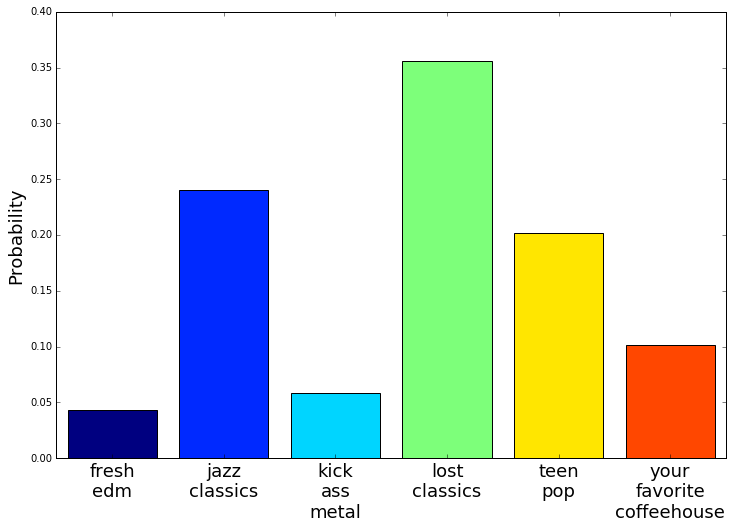

In [336]:
for genre, proba in zip(genres, y_personal_predicted_proba.mean(axis=0)):
    print("%30s %5.2f" % (genre, proba * 100))
    
plt.figure(figsize=(12, 8))
plt.bar(np.arange(0.1, 6.1, 1), y_personal_predicted_proba.mean(axis=0), color=cm(np.linspace(0.0, 1.0, 7)))
plt.xticks(np.arange(0.5, 6.5, 1), [g.replace('-', '\n') for g in genres], fontsize=18)
plt.ylabel('Probability', fontsize=18);

## And then, the final analysis

In [ ]:
import subprocess

process = subprocess.Popen(['./music-style-analyzer.sh'], stdout=subprocess.PIPE)
while process.poll() is None:
    print(process.stdout.readline().decode('utf-8').rstrip())